In [126]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import (
    DataLoader,
    TensorDataset,
    Dataset
)

from torch import nn
from torchinfo import summary
from torch.optim import (Optimizer, Adam)
from torch.nn.functional import cross_entropy
from torchmetrics import Accuracy

import matplotlib.pyplot as plt

In [112]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

filepath = "Titanic-Dataset.csv"

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "yasserh/titanic-dataset",
    filepath
)

In [188]:
"""

We want to separate out the factors we want to keep.
As well as clean them up into workable datatypes.


Columns:
    Survived: Whether or not the passenger survived.
    Pclass: The passenger's class.
    Sex: The passenger's sex.
    Age: The passenger's age.
    SibSp: # of siblings / spouses aboard.
    Parch: # of parents / children aboard.
    
"""

df = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Survived']]

In [190]:
# Convert gender to a number
df = df.replace("male", 1)
df = df.replace("female", 2)

# Replace NaN
df['Age'] = df['Age'].fillna(df['Age'].mean())



df

,Pclass,Sex,Age,SibSp,Parch,Survived
0,3,1,22.000000,1,0,0
1,1,2,38.000000,1,0,1
2,3,2,26.000000,0,0,1
3,1,2,35.000000,1,0,1
4,3,1,35.000000,0,0,0
...,...,...,...,...,...,...
886,2,1,27.000000,0,0,0
887,1,2,19.000000,0,0,1
888,3,2,29.699118,1,2,0
889,1,1,26.000000,0,0,1


In [191]:
def make_dataset(df: pd.DataFrame) -> Dataset:
    features = df.iloc[:,:-1].values
    targets = df.iloc[:, -1].values

    f_t = torch.tensor(features, dtype=torch.float32)
    t_t = torch.tensor(targets, dtype=torch.int64)

    return TensorDataset(f_t, t_t)

In [192]:
train_dataset = make_dataset(df)
(x, y) = train_dataset[0]
print(f"First input {x}. Its dtype must be {x.dtype}.")
print(f"First output {y}. Its dtype must be {y.dtype}.")

First input tensor([ 3.,  1., 22.,  1.,  0.]). Its dtype must be torch.float32.
First output 0. Its dtype must be torch.int64.


In [193]:
def make_dataloader(dataset: Dataset, batch_size: int, shuffle: bool) -> DataLoader:
    return DataLoader(dataset, batch_size, shuffle)

In [194]:
train_dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=5)
first_batch = next(iter(train_dataloader))
first_batch

[tensor([[ 3.,  1., 22.,  1.,  0.],
         [ 1.,  2., 38.,  1.,  0.],
         [ 3.,  2., 26.,  0.,  0.],
         [ 1.,  2., 35.,  1.,  0.],
         [ 3.,  1., 35.,  0.,  0.]]),
 tensor([0, 1, 1, 1, 0])]

In [195]:
"""

Going to recreate ass 1 here for a simple demonstration

"""

'\n\nGoing to recreate ass 1 here for a simple demonstration\n\n'

In [196]:
class LinearClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(5, 2)

    def forward(self, x):
        return self.linear(x)

In [197]:
m = LinearClassifier()
summary(m, input_size=(891, 5))

Layer (type:depth-idx)                   Output Shape              Param #
LinearClassifier                         [891, 2]                  --
├─Linear: 1-1                            [891, 2]                  12
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.02
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.03

In [198]:
def train(model: nn.Module, optimizer: Optimizer, dataloader: DataLoader, epochs: int):
    history = []
    accuracy = Accuracy(task='multiclass', num_classes=2)
    accuracy.reset()
    for epoch in range(epochs):
        for (x, target) in dataloader:
            pred = model(x)
            loss = cross_entropy(pred, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            accuracy.update(pred, target)
        metrics = {
            "epoch": epoch,
            "loss": loss.item(),
            "acc": accuracy.compute().item()
        }
        if epoch % (epochs // 10) == 0:
            print("{epoch}: loss={loss:.4f}, acc={acc:.2f}".format(**metrics))
        history.append(metrics)
    return pd.DataFrame(history)

In [199]:
dataloader = make_dataloader(train_dataset, shuffle=False, batch_size=891)
linearclassifier = LinearClassifier()
optimizer = Adam(linearclassifier.parameters())

history_linear = train(linearclassifier, optimizer, dataloader, 5000)

0: loss=2.1846, acc=0.38
500: loss=0.5977, acc=0.61
1000: loss=0.5152, acc=0.68
1500: loss=0.4750, acc=0.72
2000: loss=0.4564, acc=0.74
2500: loss=0.4484, acc=0.75
3000: loss=0.4452, acc=0.76
3500: loss=0.4441, acc=0.76
4000: loss=0.4437, acc=0.77
4500: loss=0.4436, acc=0.77


<Axes: >

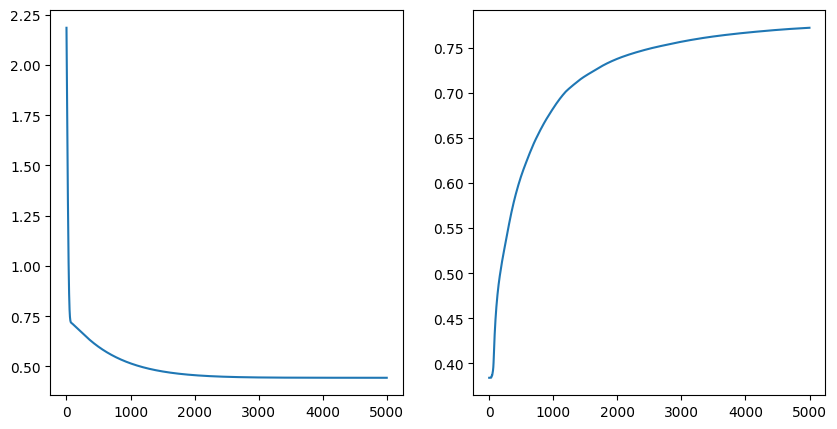

In [200]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
history_linear.loss.plot.line(ax=axes[0])
history_linear.acc.plot.line(ax=axes[1])

In [201]:
"""

Now let's do an Autoencoder model (ASSIGNMENT CONTENT)

"""

"\n\nNow let's do an Autoencoder model (ASSIGNMENT CONTENT)\n\n"

In [212]:
categorical_features = ['Pclass', 'Sex']
continuous_features = ['Age', 'SibSp', 'Parch']

df_cat = pd.get_dummies(df[categorical_features], columns=categorical_features)
df_cont = df[continuous_features].fillna(df[continuous_features].mean())


features = pd.concat([df_cat, df_cont], axis=1)


features = features.astype(float)


features = torch.tensor(features.values, dtype=torch.float32)

ae_dataset = TensorDataset(features)
ae_dataloader = DataLoader(ae_dataset, batch_size=891, shuffle=True)
input_dim = features.shape[1]

In [213]:
class TabularAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [214]:
cat_indices = list(range(df_cat.shape[1]))
cont_indices = list(range(df_cat.shape[1], input_dim))

def loss_fn(x_hat, x):
    loss_cat = nn.MSELoss()(x_hat[:, cat_indices], x[:, cat_indices])
    loss_cont = nn.MSELoss()(x_hat[:, cont_indices], x[:, cont_indices])
    return loss_cat + loss_cont

In [215]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = TabularAutoencoder(input_dim=8, latent_dim=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [216]:
num_epochs = 1000

for epoch in range(num_epochs):
    total_loss = 0
    for batch in ae_dataloader:
        x = batch[0].to(device)

        x_hat = model(x)
        loss = loss_fn(x_hat, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
    avg_loss = total_loss / len(ae_dataloader.dataset)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1} / {num_epochs}], Loss: {avg_loss:.4f}")

Epoch [10 / 1000], Loss: 341.2949
Epoch [20 / 1000], Loss: 330.1653
Epoch [30 / 1000], Loss: 317.7828
Epoch [40 / 1000], Loss: 300.5402
Epoch [50 / 1000], Loss: 276.4071
Epoch [60 / 1000], Loss: 243.1473
Epoch [70 / 1000], Loss: 199.2755
Epoch [80 / 1000], Loss: 144.2293
Epoch [90 / 1000], Loss: 83.7145
Epoch [100 / 1000], Loss: 30.4844
Epoch [110 / 1000], Loss: 3.9970
Epoch [120 / 1000], Loss: 3.8515
Epoch [130 / 1000], Loss: 3.3518
Epoch [140 / 1000], Loss: 2.0885
Epoch [150 / 1000], Loss: 2.0717
Epoch [160 / 1000], Loss: 1.9414
Epoch [170 / 1000], Loss: 1.8196
Epoch [180 / 1000], Loss: 1.7570
Epoch [190 / 1000], Loss: 1.6912
Epoch [200 / 1000], Loss: 1.6338
Epoch [210 / 1000], Loss: 1.5830
Epoch [220 / 1000], Loss: 1.5361
Epoch [230 / 1000], Loss: 1.4934
Epoch [240 / 1000], Loss: 1.4543
Epoch [250 / 1000], Loss: 1.4180
Epoch [260 / 1000], Loss: 1.3839
Epoch [270 / 1000], Loss: 1.3516
Epoch [280 / 1000], Loss: 1.3193
Epoch [290 / 1000], Loss: 1.2860
Epoch [300 / 1000], Loss: 1.2516
E

In [217]:
x_sample = features[:5].to(device)
x_recon = model(x_sample).detach().cpu()
print("Original:\n", x_sample.cpu().numpy())
print("Reconstructed:\n", x_recon.numpy())

Original:
 [[ 0.  0.  1.  1.  0. 22.  1.  0.]
 [ 1.  0.  0.  0.  1. 38.  1.  0.]
 [ 0.  0.  1.  0.  1. 26.  0.  0.]
 [ 1.  0.  0.  0.  1. 35.  1.  0.]
 [ 0.  0.  1.  1.  0. 35.  0.  0.]]
Reconstructed:
 [[ 0.11967197  0.10563852  0.720678    1.0514963  -0.03847653 21.964952
   0.96420604  0.04698515]
 [ 0.39564076  0.27211404  0.33236316  0.44814134  0.50927407 38.18788
   0.9631099   0.38631618]
 [ 0.23810759  0.15187527  0.51795626  0.41240835  0.49403554 26.066753
  -0.14241001  0.37949717]
 [ 0.35866204  0.26149106  0.36029413  0.4592526   0.49261934 35.19983
   0.9714331   0.39327466]
 [ 0.27291813  0.11002089  0.63111115  0.92665124  0.10093242 34.92082
  -0.04859766 -0.04039562]]


In [182]:
pred_pclass = x_recon[:, :3].argmax(dim=1)
pred_sex = x_recon[:, 3:5].argmax(dim=1)